In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Caso de estudio - Clasificación de texto para detección de spam en SMS

Primero vamos a cargar los datos textuales del directorio `dataset` que debería estar en nuestra directorio de cuadernos. Este directorio se creó al ejecutar el script `fetch_data.py` desde la carpeta de nivel superior del repositorio *github*.

Además, aplicamos un preprocesamiento simple y dividimos el array de datos en dos partes:
1. `text`: una lista de listas, donde cada sublista representa el contenido de nuestros sms.
2. `y`: etiqueta SPAM vs HAM en binario, los 1 son mensajes de spam mientras que los 0 son mensajes ham (no spam). 

In [38]:
import os

with open(os.path.join("datasets", "smsspam", "SMSSpamCollection")) as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

text = [x[1] for x in lines]
y = [int(x[0] == "spam") for x in lines]

In [5]:
text[:10]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, $1.50 to rcv",
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'WINNER!! As a valued network customer you have been selected to receivea $900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had you

In [6]:
y[:10]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1]

In [7]:
print('Número de mensajes de ham/spam:', np.bincount(y))

Número de mensajes de ham/spam: [4827  747]


In [8]:
type(text)

list

In [9]:
type(y)

list

Ahora dividimos nuestro dataset en dos partes, una de entrenamiento y otra de test:

In [10]:
from sklearn.model_selection import train_test_split

text_train, text_test, y_train, y_test = train_test_split(text, y, 
                                                          random_state=42,
                                                          test_size=0.25,
                                                          stratify=y)

Pasamos a usar CountVectorizer para convertir el texto a un modelo *bag-of-words*:

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

print('CountVectorizer parámetros por defecto')
CountVectorizer()

CountVectorizer parámetros por defecto


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(text_train) # Ojo, el fit se aplica sobre train

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

In [13]:
print(len(vectorizer.vocabulary_))

7453


In [14]:
X_train.shape

(4180, 7453)

In [15]:
print(vectorizer.get_feature_names()[:20])

['00', '000', '000pes', '008704050406', '0089', '01223585236', '01223585334', '02', '0207', '02072069400', '02073162414', '02085076972', '021', '03', '04', '0430', '05', '050703', '0578', '06']


In [16]:
print(vectorizer.get_feature_names()[2000:2020])

['crammed', 'cramps', 'crap', 'crash', 'crashed', 'crashing', 'crave', 'craving', 'craziest', 'crazy', 'crazyin', 'crckt', 'cream', 'created', 'creative', 'credit', 'credited', 'credits', 'creep', 'creepy']


In [50]:
print(X_train.shape)
print(X_test.shape)

(4180, 3439)
(1394, 3439)


### Entrenar un clasificador para texto

Ahora vamos a entrenar un clasificador, la regresión logística, que funciona muy bien como base para tareas de clasificación de textos:

In [58]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Evaluamos el rendimiento del clasificador en el conjunto de test. Vamos a utilizar la función de *score* por defecto, que sería el porcentaje de patrones bien clasificados:

In [60]:
clf.score(X_test, y_test)

0.9835007173601148

También podemos calcular la puntuación en entrenamiento:

In [61]:
clf.score(X_train, y_train)

0.995933014354067

# Visualizar las características más importantes

In [62]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # Obtener los coeficientes más importantes (negativos o positivos)
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # representarlos
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 2 * n_top_features+1), feature_names[interesting_coefficients], rotation=60, ha="right");

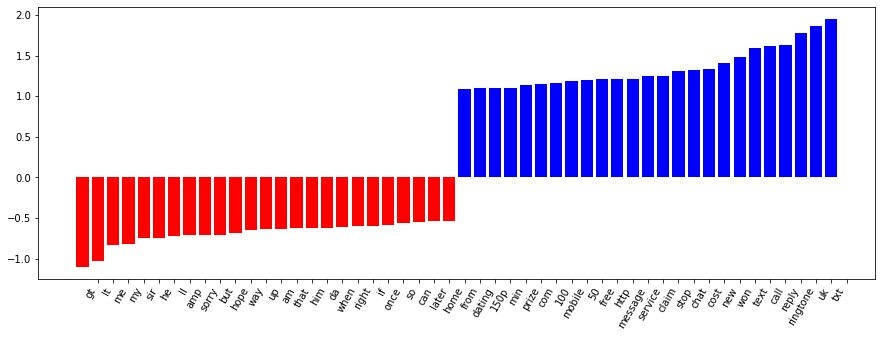

In [63]:
visualize_coefficients(clf, vectorizer.get_feature_names())

In [64]:
vectorizer = CountVectorizer(min_df=2)
vectorizer.fit(text_train)

X_train = vectorizer.transform(text_train)
X_test = vectorizer.transform(text_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.995933014354067
0.9835007173601148


In [65]:
len(vectorizer.get_feature_names())

3439

In [66]:
print(vectorizer.get_feature_names()[:20])

['00', '000', '01223585334', '02', '0207', '02073162414', '03', '04', '05', '0578', '06', '07', '07123456789', '07781482378', '07821230901', '07xxxxxxxxx', '0800', '08000839402', '08000930705', '08000938767']


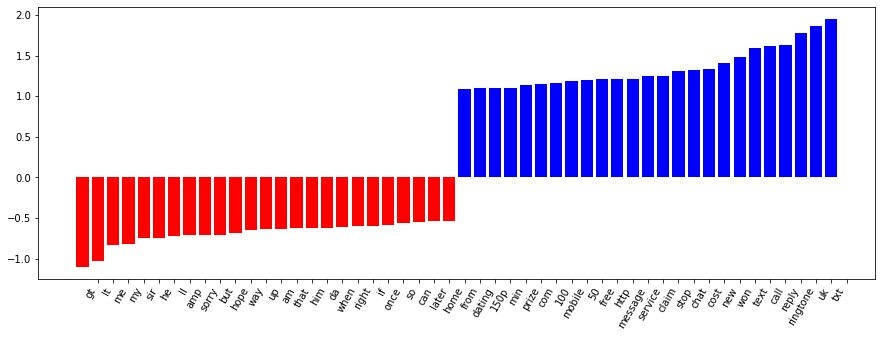

In [67]:
visualize_coefficients(clf, vectorizer.get_feature_names())

<img src="figures/supervised_scikit_learn.png" width="100%">

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      Utiliza TfidfVectorizer en lugar de CountVectorizer. ¿Mejoran los resultados? ¿Han cambiado los coeficientes?
      </li>
      <li>
      Cambia los parámetros min_df y ngram_range del TfidfVectorizer y el CountVectorizer. ¿Cambian las características que se seleccionan como más importantes?
      </li>
    </ul>
</div>

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,2))
tfidf_vectorizer.fit(text_train)

X_train_tfidf = tfidf_vectorizer.transform(text_train)

X_test_tfidf = tfidf_vectorizer.transform(text_test)

len(tfidf_vectorizer.get_feature_names())

1208

In [133]:
clf2 = LogisticRegression()
clf2.fit(X_train_tfidf, y_train)

print("con CountVectorizer:")
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

print("\ncon TfidfVectorizer:")
print(clf2.score(X_train_tfidf, y_train))
print(clf2.score(X_test_tfidf, y_test))

con CountVectorizer:
0.995933014354067
0.9835007173601148

con TfidfVectorizer:
0.9815789473684211
0.9813486370157819


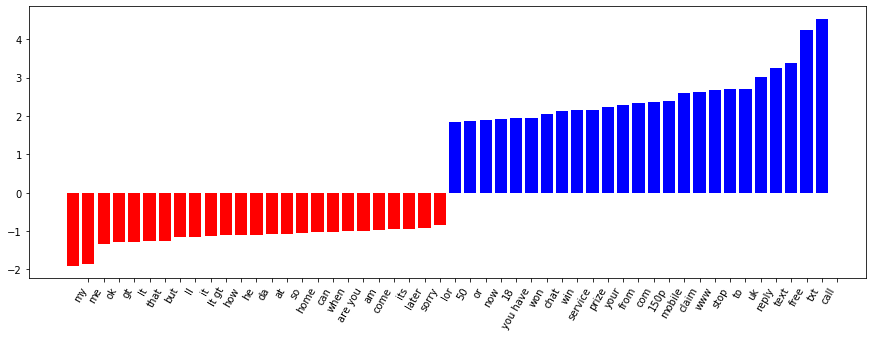

In [134]:
visualize_coefficients(clf2, tfidf_vectorizer.get_feature_names())

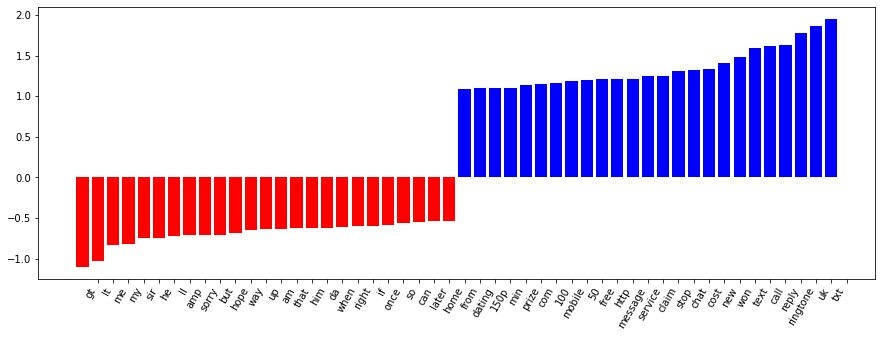

In [81]:
visualize_coefficients(clf, vectorizer.get_feature_names())

In [82]:
print(tfidf_vectorizer.transform(text_train) == np.max(tfidf_vectorizer.transform(text_train)))

  (15, 2188)	True
  (65, 2971)	True
  (90, 2167)	True
  (259, 1768)	True
  (314, 3425)	True
  (422, 2974)	True
  (523, 1845)	True
  (647, 2164)	True
  (656, 2164)	True
  (741, 2124)	True
  (1151, 3436)	True
  (1295, 2167)	True
  (1321, 2164)	True
  (1557, 3436)	True
  (1581, 2164)	True
  (1639, 2167)	True
  (1738, 3436)	True
  (1953, 2164)	True
  (2020, 2073)	True
  (2063, 1515)	True
  (2118, 2164)	True
  (2169, 2164)	True
  (2176, 2164)	True
  (2202, 404)	True
  (2224, 2139)	True
  (2255, 3311)	True
  (2368, 2164)	True
  (2391, 2164)	True
  (2608, 1515)	True
  (2620, 1466)	True
  (2657, 405)	True
  (2714, 2167)	True
  (2886, 2164)	True
  (2912, 2164)	True
  (2926, 2999)	True
  (3188, 3421)	True
  (3271, 2167)	True
  (3280, 370)	True
  (3466, 2558)	True
  (3524, 2210)	True
  (3600, 2167)	True
  (3628, 2577)	True
  (3734, 1036)	True
  (3863, 2164)	True
  (3868, 2164)	True
  (3987, 1278)	True


In [86]:
tfidf_vectorizer.get_feature_names()[1278]

'for'